In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from scipy.stats import chi2_contingency, spearmanr, skew, pearsonr, zscore, stats
from sklearn.metrics import r2_score, roc_curve, auc, confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression

In [3]:
data = pd.read_csv('D:/Python_Code/VP Bank Intern Projects/1.Delinquent Debt  Again/Data-test-TTS.csv')
data

,APP_ID,BAD,APPMONTHPAYMENT,NATIONALID_DATE,CREDITSUM,PRIMARYINCOME,RATIO_INST_PER_INCOME,APPEDUCATION,PRODUCT
0,225042,0,1786000,5.33,15825000.0,12000000,0.178600,High School,NaN
1,80968,0,2257000,6.32,15000000.0,5000000,0.550488,Middle School,NaN
2,158503,1,1730000,4.08,14770000.0,8000000,0.247143,Basic School,NaN
3,121869,0,1951000,2.05,20000000.0,11000000,0.243875,High School,Secured normal customer
4,160681,1,2059000,0.62,31650000.0,15000000,0.158385,Master Degree,Secured normal customer
...,...,...,...,...,...,...,...,...,...
105266,128917,0,1191000,2.27,10550000.0,20000000,0.066167,Middle School,NaN
105267,176369,0,1886000,9.65,31650000.0,6000000,0.369804,Middle School,Secured priority customer
105268,36002,0,2097000,12.85,32250000.0,10000000,0.233000,High School,Secured normal customer
105269,132658,0,1530000,0.09,21100000.0,7000000,0.250820,Basic School,NaN


In [4]:
data.isnull().sum()

APP_ID                       0
BAD                          0
APPMONTHPAYMENT              0
NATIONALID_DATE              0
CREDITSUM                  871
PRIMARYINCOME                0
RATIO_INST_PER_INCOME      871
APPEDUCATION               871
PRODUCT                  28993
dtype: int64

# **FUNCTION**

In [3]:
#Hàm tính WOE vs IV cho các biến
def calculate_odds_bad_rate(data, feature, target):
    # Tính tổng số trường hợp và tổng số "bad" cho mỗi giá trị của feature
    feature_group = data.groupby(feature)[target].agg(['sum', 'count'])
    feature_group.columns = ['bad', 'total']
    # Tính số trường hợp "good"
    feature_group['good'] = feature_group['total'] - feature_group['bad']
    # Tính tỷ lệ bad và good
    feature_group['bad_rate'] = feature_group['bad'] / feature_group['total']
    feature_group['good_rate'] = feature_group['good'] / feature_group['total']
    # Tính Odds
    feature_group['odds'] = feature_group['good'] / feature_group['bad']
    # Tính tổng số trường hợp "good" và "bad" để tính WOE và IV
    total_good = feature_group['good'].sum()
    total_bad = feature_group['bad'].sum()
    # Tính WOE và IV
    feature_group['WOE'] = np.log((feature_group['good'] / total_good) / (feature_group['bad'] / total_bad))
    feature_group['IV'] = (feature_group['good'] / total_good - feature_group['bad'] / total_bad) * feature_group['WOE']
    # Xử lý các giá trị vô hạn hoặc lỗi chia 0 (do log hoặc chia cho 0)
    feature_group.replace([np.inf, -np.inf], np.nan, inplace=True)
    feature_group.fillna(0, inplace=True)
    
    # Tính tổng IV cho tất cả các nhóm
    total_iv = feature_group['IV'].sum()
    print(f"Total IV for {feature}: {total_iv:.4f}")
    
    return feature_group[['good', 'bad', 'good_rate', 'bad_rate', 'odds', 'WOE', 'IV']]

In [4]:
#Hàm đánh giá hiệu suất
def print_scores(y_test, y_pred):
  print(classification_report(y_test, y_pred))

#Hàm chia tập train-test và MinMax Scaler
def preprocess_data(data):

    # Chia tập train-test
    X = data.drop(columns=['BAD'], axis=1)
    y = data['BAD']

    X_train, y_train = X, y

    #Standard Scaler:
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)

    return X_train, y_train

# Hàm tính Cross Validation
def cross_val(model, X_train, y_train):
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print("Cross-validation scores:", cv_scores)
    print("Mean CV score:", cv_scores.mean())
    print("Standard deviation of CV score:", cv_scores.std())
    return cv_scores, cv_scores.mean(), cv_scores.std()

#Hàm tính Gini
def gini_coefficient(y_true, y_pred):
    # Tính chỉ số Gini từ AUC
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

In [5]:
#Hàm train, test
def train_test_model(model, X_train, y_train):
    print(f"Model:", model)
    model.fit(X_train, y_train)
    
    # Dự đoán cho tập huấn luyện và tập kiểm tra
    y_train_pred = model.predict(X_train)

    # Tính xác suất dự đoán và hệ số Gini cho tập huấn luyện
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    gini_train = gini_coefficient(y_train, y_train_pred_prob)

    # In các chỉ số đánh giá cho tập huấn luyện
    print_scores(y_train, y_train_pred)
    print("Gini train:", gini_train)
    
    # Thực hiện đánh giá chéo (cross-validation)
    cv_scores, cv_mean, cv_std = cross_val(model, X_train, y_train)

C:\Users\CAOVU\AppData\Local\Temp\ipykernel_11772\1106161577.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['APPEDUCATION'], rotation=90)


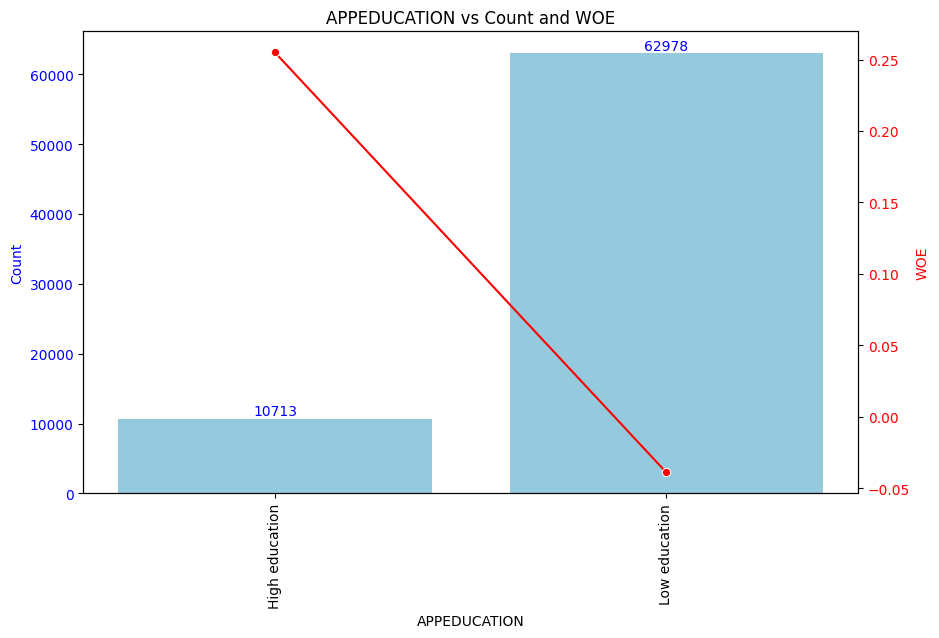

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dữ liệu
data = {
    'APPEDUCATION': [
        'High education', 'Low education'
    ],
    'WOE': [0.255, -0.039],

    'Count': [10713, 62978]
}
df = pd.DataFrame(data)

# Kích thước và thiết lập chung
fig, ax1 = plt.subplots(figsize=(10, 6))

# Biểu đồ cột (barchart) thể hiện số lượng
sns.barplot(x='APPEDUCATION', y='Count', data=df, ax=ax1, color='skyblue')
ax1.set_xlabel('APPEDUCATION')
ax1.set_ylabel('Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(df['APPEDUCATION'], rotation=90)

# Thêm số lượng trên đỉnh mỗi cột
for index, value in enumerate(df['Count']):
    ax1.text(index, value + 500, str(value), ha='center', color='blue')

# Biểu đồ đường (linechart) thể hiện WOE
ax2 = ax1.twinx()
sns.lineplot(x='APPEDUCATION', y='WOE', data=df, marker='o', ax=ax2, color='red')
ax2.set_ylabel('WOE', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('APPEDUCATION vs Count and WOE')
plt.show()

# **I. CHECKING DỮ LIỆU**

***Bù vào CREDITSUM một dữ liệu bất kì (để fillna) vì cột này không cần dùng***

In [4]:
data.isnull().sum()

APP_ID                       0
BAD                          0
APPMONTHPAYMENT              0
NATIONALID_DATE              0
CREDITSUM                    0
PRIMARYINCOME                0
RATIO_INST_PER_INCOME      871
APPEDUCATION               871
PRODUCT                  28993
dtype: int64

***Fill NaN cho RATIO_INST_PER_INCOME***

In [5]:
z = 0.8687378233570745
data['RATIO_INST_PER_INCOME'] = data['RATIO_INST_PER_INCOME'].fillna(data['APPMONTHPAYMENT']/data['PRIMARYINCOME']/z)

***Những dữ liệu bị thiếu trong PRODUCT có thể ám chỉ rằng: trước đây người vay chưa từng vay*** 

In [6]:
#Sinh thêm 1 giá trị là 'No product in past', ám chỉ việc người vay chưa từng vay trong quá khứ:
data['PRODUCT'] = data['PRODUCT'].apply(lambda x: 'No product in past' if pd.isna(x) else x)

***APPEDUCATION***

In [7]:
#Bù đắp bằng giá trị phổ biến nhất, do Null không quá nhiều
data['APPEDUCATION'] = data['APPEDUCATION'].fillna('High School')

***NATIONALID_DATE***

In [8]:
data['NATIONALID_DATE'] = data['NATIONALID_DATE'].replace([-0.02, -0.01], [0.02, 0.01])

***Vậy là dữ liệu đã hết Null***

In [12]:
data.isnull().sum()

APP_ID                   0
BAD                      0
APPMONTHPAYMENT          0
NATIONALID_DATE          0
CREDITSUM                0
PRIMARYINCOME            0
RATIO_INST_PER_INCOME    0
APPEDUCATION             0
PRODUCT                  0
dtype: int64

# **FIXING VALUES**

***Ở đây, ta sẽ bổ sung vào các giá trị phổ biến một số lẻ rất nhỏ, để cho số lượng các bins khi chia sẽ được đồng đều***

***PRIMARYINCOME***

In [17]:
data['PRIMARYINCOME'] = data['PRIMARYINCOME'].astype(float)
specific_PRIMARYINCOME = [10000000, 8000000, 15000000, 7000000, 9000000, 12000000, 6000000, 20000000, 
                          5000000, 7500000, 6500000, 13000000, 11000000, 18000000, 8500000]
for i in specific_PRIMARYINCOME:
    increment = 0.001
    indices = data[data['PRIMARYINCOME'] == i].index
    increments = np.arange(0, increment * len(indices), increment)
    data.loc[indices, 'PRIMARYINCOME'] += increments

In [18]:
data['Income_Bins'], bins = pd.qcut(data['PRIMARYINCOME'], q=20, labels=False, retbins=True)
bin_counts = data['Income_Bins'].value_counts(sort=False)
print(bin_counts)

Income_Bins
13    5264
0     5338
5     5264
16    5241
2     5263
18    5263
8     5263
1     5190
15    5286
3     5264
10    5263
19    5264
7     5264
14    5263
6     5263
11    5264
9     5264
17    5264
4     5263
12    5263
Name: count, dtype: int64


***APPMONTHPAYMENT***

In [19]:
data['APPMONTHPAYMENT'] = data['APPMONTHPAYMENT'].astype(float)
specific_APPMONTHPAYMENT = [1912000, 3176000, 1530000, 2796000, 2059000, 1191000, 2257000, 2238000, 2058000, 2381000, 
                            1373000, 1119000, 2976000, 1656000, 2097000, 1948000, 1812000, 2484000, 3143000, 1372000, 3425000]
for i in specific_APPMONTHPAYMENT:
    increment = 0.001
    indices = data[data['APPMONTHPAYMENT'] == i].index
    increments = np.arange(0, increment * len(indices), increment)
    data.loc[indices, 'APPMONTHPAYMENT'] += increments

In [20]:
data['Payment_Bins'], bins = pd.qcut(data['APPMONTHPAYMENT'], q=20, labels=False, retbins=True)
bin_counts = data['Payment_Bins'].value_counts(sort=False)
print(bin_counts)

Payment_Bins
7     5265
12    5321
6     5331
9     5405
10    5122
3     4889
17    5224
5     5264
15    4958
2     5639
4     5262
14    4688
11    5407
0     5264
1     5264
8     5194
18    5329
19    5198
16    5303
13    5944
Name: count, dtype: int64


In [21]:
data = data.drop(columns = ['Income_Bins', 'Payment_Bins'])

***APPEDUCATION: Phân chia các giá trị thành các nhóm trình độ từ cao-thấp***

In [22]:
data['APPEDUCATION'] = data['APPEDUCATION'].replace({
    'Bachelor': 'High education',
    'Master Degree': 'High education',
    'College': 'High education',
    'Working Cerfiticate': 'Low education',
    'High School': 'Low education',
    'Middle School': 'Low education',
    'Basic School': 'Low education',
    'No Education': 'Low education'
})

***PRODUCT: Nhóm một số giá trị lại với nhau***

In [24]:
data['PRODUCT'] = data['PRODUCT'].replace({
    'Special product (priority customer)': 'Special product (Normal + Priority)', 
    'Special product (Normal customer)': 'Special product (Normal + Priority)'})

# **ADD NEW COLS**

***1.Potential_Score***

In [26]:
#Column đánh giá chỉ số tiềm năng của khách hàng, bằng cách nhân Thu nhập vs Độ tuổi, dùng hàm Log để tinh gọn giá trị
data['Potential_Score'] = np.log(data['PRIMARYINCOME']/1000000 * data['NATIONALID_DATE'])

#Đổi các giá trị -Inf (âm vô cực) thành -10, ám chỉ rằng rất nhỏ
data['Potential_Score'] = data['Potential_Score'].replace(-np.inf, -10)

C:\Users\CAOVU\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
